In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import glob
import cv2
import os
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader,Dataset
import albumentations as albu
from skimage.color import gray2rgb
from sklearn.utils import resample
import functools
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_csv_path = '/kaggle/input/df-filtered-after-eda/final_df_Pulmonary_Embolism_CT_scans_data.csv'
jpeg_dir = '/kaggle/input/rsna-str-pe-detection-jpeg-256/train-jpegs'

In [3]:
train_df = pd.read_csv(train_csv_path)
train_df.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,...,table_height,x_ray_tube_current,exposure,patient_position,detector_tilt,bits_allocated,rescale_intercept,rescale_slope,photometric_interpretation,convolution_kernel
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,...,139.0,964,124,HFS,0.0,16,-1024.0,1.0,MONOCHROME2,B30f
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,...,139.0,964,124,HFS,0.0,16,-1024.0,1.0,MONOCHROME2,B30f
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,...,139.0,964,124,HFS,0.0,16,-1024.0,1.0,MONOCHROME2,B30f
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,...,139.0,964,124,HFS,0.0,16,-1024.0,1.0,MONOCHROME2,B30f
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,...,139.0,964,124,HFS,0.0,16,-1024.0,1.0,MONOCHROME2,B30f


In [4]:
len(train_df)

1592613

In [5]:
df_disease = train_df[train_df['pe_present_on_image'] == 1]
len(df_disease)

92096

In [6]:
columnas_a_mantener = [
    'StudyInstanceUID', 
    'SeriesInstanceUID', 
    'SOPInstanceUID', 
    'rv_lv_ratio_gte_1', 
    'rv_lv_ratio_lt_1', 
    'leftsided_pe', 
    'chronic_pe', 
    'rightsided_pe', 
    'acute_and_chronic_pe', 
    'central_pe'
]

# Filter
df = df_disease[columnas_a_mantener]

print(df)

        StudyInstanceUID SeriesInstanceUID SOPInstanceUID  rv_lv_ratio_gte_1  \
63          6897fa9de148      2bfbb7fd2e8b   c1a5538bba20                  0   
64          6897fa9de148      2bfbb7fd2e8b   fd9db7e0cffe                  0   
65          6897fa9de148      2bfbb7fd2e8b   1f108fe8cae4                  0   
75          6897fa9de148      2bfbb7fd2e8b   2a6b4c0ef0e5                  0   
76          6897fa9de148      2bfbb7fd2e8b   21c2645ae16d                  0   
...                  ...               ...            ...                ...   
1592590     4833c9b6a5d0      57e3e3c5f910   6f696c439df7                  0   
1592591     4833c9b6a5d0      57e3e3c5f910   48ecddad6ec3                  0   
1592592     4833c9b6a5d0      57e3e3c5f910   40f943bb1e01                  0   
1592602     4833c9b6a5d0      57e3e3c5f910   3696e01d1286                  0   
1592612     4833c9b6a5d0      57e3e3c5f910   f890efd48940                  0   

         rv_lv_ratio_lt_1  leftsided_pe

In [ ]:
def get_training_augmentation(y=256, x=256):
    train_transform = [
        #albu.RandomBrightnessContrast(p=0.3),
        albu.VerticalFlip(p=0.5),
        albu.HorizontalFlip(p=0.5),
        albu.Rotate(limit=20, p=0.5),
        albu.RandomResizedCrop(height=y, width=x, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
        albu.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        albu.GridDistortion(p=0.3),
        albu.Downscale(p=0.5, scale_min=0.35, scale_max=0.75),
        albu.ToGray(p=1.0),  # Aplicar escala de grises
        albu.Resize(y, x)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation(y=256, x=256):
    test_transform = [
        albu.CenterCrop(height=int(y * 0.8), width=int(x * 0.8), p=1.0),
        albu.Resize(y, x)
    ]
    return albu.Compose(test_transform)

In [7]:
def preprocess_input(x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs):
    if input_space == "BGR":
        x = x[..., ::-1].copy()
        
    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0         
    if mean is not None:
        mean = np.array(mean)
        x = x - mean
    if std is not None:
        std = np.array(std)
        x = x / std
    return x

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)



def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')

class CTDataset2D(Dataset):
    def __init__(self, df, transforms=albu.Compose([albu.HorizontalFlip()]), preprocessing=None, size=256, mode='val'):
        self.df_main = df.values
        self.df = self.df_main  # test 
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.size = size

    def __getitem__(self, idx):
        row = self.df[idx]
        img = cv2.imread(glob.glob(f"{jpeg_dir}/{row[0]}/{row[1]}/*{row[2]}.jpg")[0])
        label = row[3:].astype(int)
        label[2:] = label[2:] if label[0]==1 else 0
        if self.transforms:
            img = self.transforms(image=img)['image']
        if self.preprocessing:
            img = self.preprocessing(image=img)['image']
        return img,torch.from_numpy(label.reshape(-1))

    def __len__(self):
        return len(self.df)        

def norm(img):
    img-=img.min()
    return img/img.max()

In [8]:
'''def filter_slices(group):
    n = len(group)
    start = int(0.1 * n)
    end = int(0.9 * n)
    return group.iloc[start:end]

# Aplicar la función de filtrado a cada grupo
train_df_80 = df.groupby('SeriesInstanceUID').apply(filter_slices).reset_index(drop=True)
len(train_df_80)'''

73662

In [9]:
StudyInstanceUID = list(set(train_df_80['StudyInstanceUID']))
print(len(StudyInstanceUID))

2068


In [10]:
t_df = train_df_80[train_df_80['StudyInstanceUID'].isin(StudyInstanceUID[0:1447])] #70% train 
v_df = train_df_80[train_df_80['StudyInstanceUID'].isin(StudyInstanceUID[1447:1860])] #20% validation-test
final_val_df = train_df_80[train_df_80['StudyInstanceUID'].isin(StudyInstanceUID[1860:2068])] #10% validation-test

In [11]:
class config:
    model_name="Model - multiclass - image level"
    batch_size = 128
    WORKERS = 4
    classes = 7
    resume = False
    epochs = 10
    MODEL_PATH = 'log/cpt'
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

In [12]:
formatted_settings = {
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],}

preprocessing_fn = functools.partial(preprocess_input, **formatted_settings)

train_dataset = CTDataset2D(t_df,
                            transforms=get_training_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn),mode='train')

val_dataset = CTDataset2D(v_df,
                            transforms=get_validation_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn))

final_val_dataset = CTDataset2D(final_val_df,
                            transforms=get_validation_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn))

In [13]:
train = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.WORKERS, pin_memory=True) 
val = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.WORKERS, pin_memory=True) 
final_val = DataLoader(final_val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.WORKERS, pin_memory=True) 

In [8]:
pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9cd14a2ef6a6d33409a2121fb3a54da0b359946f5f51a895edaf9654b0e4a48f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch
Note: you may need to restart the kernel to use updated packages.


In [17]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 7)
model = model.cuda()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 93.3MB/s]


Loaded pretrained weights for efficientnet-b0


In [18]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay= 0.00001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max= 300,eta_min= 0.00001)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

class trainer:
    def __init__(self,loss_fn,model,optimizer, scheduler):
        self.loss_fn = loss_fn
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler

        
    def batch_train(self, batch_imgs, batch_labels, batch_idx):

        batch_imgs, batch_labels = batch_imgs.cuda().float(), batch_labels.cuda().float()        
        predicted = self.model(batch_imgs)
        loss = self.loss_fn(predicted.float(), batch_labels)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item(), predicted
    
    def batch_valid(self, batch_imgs,get_fet):
        self.model.eval()
        
        batch_imgs = batch_imgs.cuda()
        with torch.no_grad():
            predicted = self.model(batch_imgs)
        predicted = torch.sigmoid(predicted)
        return predicted
    
    def train_epoch(self, loader):
        self.model.train()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            loss, predicted = self.batch_train(imgs, labels, batch_idx)
            current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
            tqdm_loader.set_description('loss: {:.4} lr:{:.6}'.format(
                    current_loss_mean, self.optimizer.param_groups[0]['lr']))
            self.scheduler.step(batch_idx)
        return current_loss_mean
    
    def valid_epoch(self, loader,name="valid"):
        self.model.eval()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            with torch.no_grad():
                batch_imgs = imgs.cuda().float()
                batch_labels = labels.cuda()
                predicted = self.model(batch_imgs)
                loss = self.loss_fn(predicted.float(),batch_labels.float()).item()
                current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
        score = 1-current_loss_mean
        print('metric {}'.format(score))
        return score
    
    def run(self,train_loder,val_loder):
        best_score = -100000
        for e in range(config.epochs):
            print("----------Epoch {}-----------".format(e))
            current_loss_mean = self.train_epoch(train_loder)
            '''train_loder.dataset.update_train_df()'''
            score = self.valid_epoch(val_loder)
            if best_score < score:
                best_score = score
                torch.save(self.model.state_dict(),config.MODEL_PATH+"/{}_best.pth".format(config.model_name))

    def batch_valid_tta(self, batch_imgs):
        
        batch_imgs = batch_imgs.cuda()
        predicted = model(batch_imgs)
        tta_flip = [[-1],[-2]]
        for axis in tta_flip:
            predicted += torch.flip(model(torch.flip(batch_imgs, axis)), axis)
        predicted = predicted/(1+len(tta_flip))
        predicted = torch.sigmoid(predicted)
        return predicted.cpu().numpy()
            
    def load_best_model(self):
        if os.path.exists(config.MODEL_PATH+"/{}_best.pth".format(config.model_name)):
            self.model.load_state_dict(torch.load(config.MODEL_PATH+"/{}_best.pth".format(config.model_name)))
        
    def predict(self,imgs_tensor,get_fet = False):
        self.model.train()
        with torch.no_grad():
            return self.batch_valid(imgs_tensor,get_fet=get_fet)

In [20]:
Trainer = trainer(loss_fn,model,optimizer,scheduler)

In [48]:
'''import gc
gc.collect()
torch.cuda.empty_cache()'''

In [21]:
Trainer.run(train,val)

----------Epoch 0-----------


  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

metric 0.43312566111406947
----------Epoch 1-----------


  0%|          | 0/397 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7965f16a1000>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7965f16a1000>  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()    
Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7965f16a1000>  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():    Traceback (most recent call last):

if w.is_alive():
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, i

  0%|          | 0/127 [00:00<?, ?it/s]

metric -2.7959277409268184
----------Epoch 2-----------


  0%|          | 0/397 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7965f16a1000>
Traceback (most recent call last):
Exception ignored in:   File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7965f16a1000>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 

  0%|          | 0/127 [00:00<?, ?it/s]

metric 0.029716418777394393
----------Epoch 3-----------


  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

metric 0.1397752163447733
----------Epoch 4-----------


  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

metric -0.21234212897893956
----------Epoch 5-----------


  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7965f16a1000>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7965f16a1000>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()
    self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    Exception ignored in: if w.is_alive():  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

<function _MultiProcessingDataLoaderIter.__del__ at 0x7965f16a1000>
    if w.is_alive():Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "

metric -0.653502849143321
----------Epoch 6-----------


  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7965f16a1000>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7965f16a1000>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7965f16a1000>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/t

metric -1.3932972555085432
----------Epoch 7-----------


  0%|          | 0/397 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7965f16a1000>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7965f16a1000>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.i

  0%|          | 0/127 [00:00<?, ?it/s]

metric -1.7587345791613966
----------Epoch 8-----------


  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

metric -2.9540893599742986
----------Epoch 9-----------


  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

metric -1.8547590914673693


In [23]:
predictions = []
true_labels = []
for images, labels in final_val:
    images = images.cuda().float()
    true_labels.extend(labels.cpu().numpy())
    with torch.no_grad():
        pred = Trainer.predict(images)
        predictions.extend(pred.cpu().numpy())
predictions = np.array(predictions)
true_labels = np.array(true_labels)

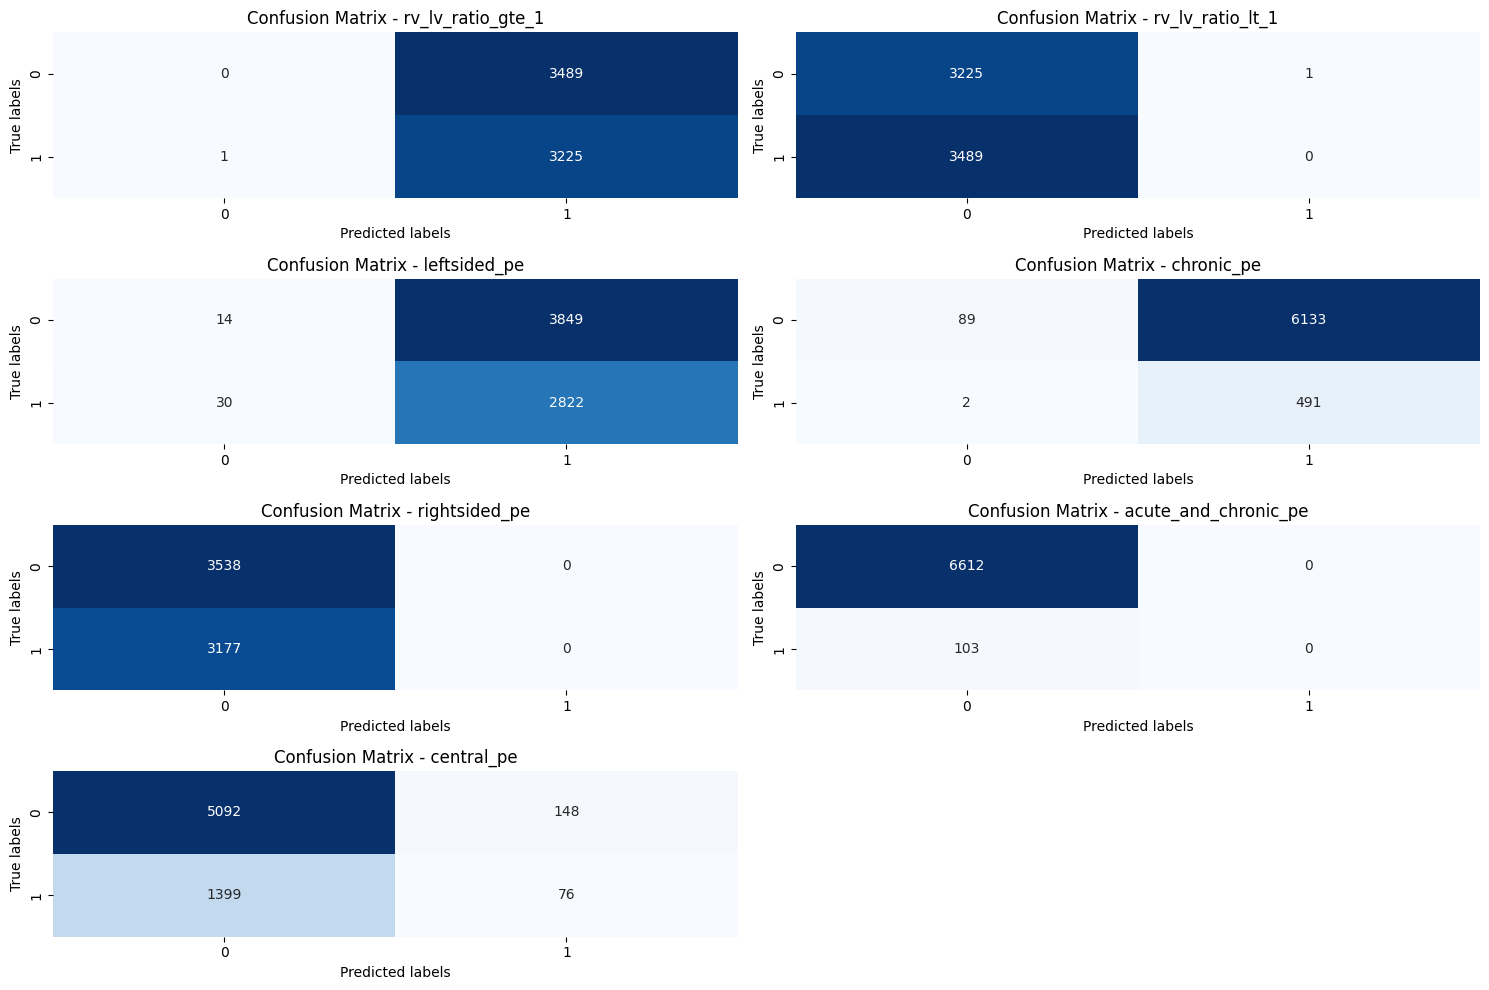

In [36]:
def multilabel_confusion_matrix(true_labels, predicted_labels, num_classes):
    confusion_matrix = np.zeros((num_classes, 2, 2), dtype=np.int32)
    
    for i in range(num_classes):
        true_positive = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 1))
        false_negative = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 0))
        false_positive = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 1))
        true_negative = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 0))
        
        confusion_matrix[i] = np.array([[true_negative, false_positive],
                                        [false_negative, true_positive]])
    return confusion_matrix
num_classes = true_labels.shape[1]  
class_names = ['rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1', 'leftsided_pe', 'chronic_pe', 'rightsided_pe', 'acute_and_chronic_pe', 'central_pe']
predicted_labels = np.round(predictions)
conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(15, 10))  
rows = (num_classes + 1) // 2  

for i in range(num_classes):
    plt.subplot(rows, 2, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f"Confusion Matrix - {class_names[i]}")  
plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda().float()
            labels = labels.cuda().float()
            preds = model(imgs)
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)
    cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
    print("Precision por clase: ", precision)
    print("Recall por clase: ", recall)
    print("F1-Score por clase: ", f1)
    print("\nMatriz de Confusión:\n", cm)
    print("\nReporte Completo:\n", classification_report(all_labels, all_preds, target_names=['rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1', 'leftsided_pe', 'chronic_pe', 'rightsided_pe', 'acute_and_chronic_pe', 'central_pe']))

evaluate_model(model, final_val)

Precision por clase:  [0.48033959 0.         0.42302503 0.0741244  0.         0.
 0.33928571]
Recall por clase:  [0.99969002 0.         0.98948107 0.9959432  0.         0.
 0.05152542]
F1-Score por clase:  [0.64889336 0.         0.59267038 0.13797949 0.         0.
 0.08946439]

Matriz de Confusión:
 [[3225    1]
 [3489    0]]

Reporte Completo:
                       precision    recall  f1-score   support

   rv_lv_ratio_gte_1       0.48      1.00      0.65      3226
    rv_lv_ratio_lt_1       0.00      0.00      0.00      3489
        leftsided_pe       0.42      0.99      0.59      2852
          chronic_pe       0.07      1.00      0.14       493
       rightsided_pe       0.00      0.00      0.00      3177
acute_and_chronic_pe       0.00      0.00      0.00       103
          central_pe       0.34      0.05      0.09      1475

           micro avg       0.33      0.45      0.38     14815
           macro avg       0.19      0.43      0.21     14815
        weighted avg       0.2

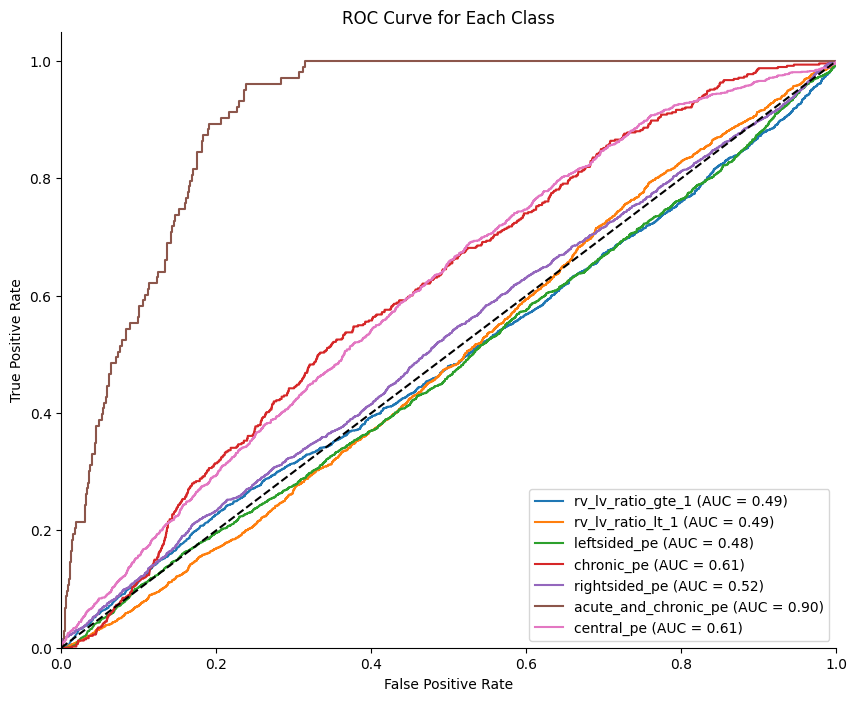

In [32]:
def plot_roc_curve(true_labels, predicted_probs, label_names):
    plt.figure(figsize=(10, 8))
    
    for i, label_name in enumerate(label_names):
        fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(label_name, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    sns.despine()
    plt.show()

label_names = ['rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1', 'leftsided_pe', 'chronic_pe', 'rightsided_pe', 'acute_and_chronic_pe', 'central_pe']
plot_roc_curve(true_labels, predictions, label_names)

# Model 1 (Location: LEFTSIDED_PE, RIGHTSIDED_PE, CENTRAL_PE)

In [10]:
model1_columnas_a_mantener = [
    'StudyInstanceUID', 
    'SeriesInstanceUID', 
    'SOPInstanceUID',  
    'leftsided_pe', 
    'rightsided_pe',
    'central_pe'
]

# Filter
df_model1 = df_disease[model1_columnas_a_mantener]

print(df_model1)

        StudyInstanceUID SeriesInstanceUID SOPInstanceUID  leftsided_pe  \
63          6897fa9de148      2bfbb7fd2e8b   c1a5538bba20             1   
64          6897fa9de148      2bfbb7fd2e8b   fd9db7e0cffe             1   
65          6897fa9de148      2bfbb7fd2e8b   1f108fe8cae4             1   
75          6897fa9de148      2bfbb7fd2e8b   2a6b4c0ef0e5             1   
76          6897fa9de148      2bfbb7fd2e8b   21c2645ae16d             1   
...                  ...               ...            ...           ...   
1592590     4833c9b6a5d0      57e3e3c5f910   6f696c439df7             1   
1592591     4833c9b6a5d0      57e3e3c5f910   48ecddad6ec3             1   
1592592     4833c9b6a5d0      57e3e3c5f910   40f943bb1e01             1   
1592602     4833c9b6a5d0      57e3e3c5f910   3696e01d1286             1   
1592612     4833c9b6a5d0      57e3e3c5f910   f890efd48940             1   

         rightsided_pe  central_pe  
63                   1           0  
64                   1   

In [11]:
def get_training_augmentation(y=256, x=256):
    train_transform = [
        #albu.RandomBrightnessContrast(p=0.3),
        albu.VerticalFlip(p=0.5),
        albu.HorizontalFlip(p=0.5),
        albu.Rotate(limit=20, p=0.5),
        albu.CenterCrop(height=int(y * 0.8), width=int(x * 0.8), p=1.0),
        albu.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        albu.GridDistortion(p=0.3),
        albu.Downscale(p=0.5, scale_min=0.35, scale_max=0.75),
        albu.ToGray(p=1.0),  # Aplicar escala de grises
        albu.Resize(y, x)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation(y=256, x=256):
    test_transform = [
        albu.CenterCrop(height=int(y * 0.8), width=int(x * 0.8), p=1.0),
        albu.Resize(y, x)
    ]
    return albu.Compose(test_transform)

In [12]:
StudyInstanceUID = list(set(df_model1['StudyInstanceUID']))
print(len(StudyInstanceUID))

2084


In [13]:
t_df = df_model1[df_model1['StudyInstanceUID'].isin(StudyInstanceUID[0:1447])] #70% train 
v_df = df_model1[df_model1['StudyInstanceUID'].isin(StudyInstanceUID[1447:1860])] #20% validation-test
final_val_df = df_model1[df_model1['StudyInstanceUID'].isin(StudyInstanceUID[1860:2084])] #10% validation-test

In [14]:
class config:
    model_name="Model 1 Location - multiclass"
    batch_size = 128
    WORKERS = 4
    classes = 3
    resume = False
    epochs = 5
    MODEL_PATH = 'log/cpt'
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

In [15]:
formatted_settings = {
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],}

preprocessing_fn = functools.partial(preprocess_input, **formatted_settings)

train_dataset = CTDataset2D(t_df,
                            transforms=get_training_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn),mode='train')

val_dataset = CTDataset2D(v_df,
                            transforms=get_validation_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn))

final_val_dataset = CTDataset2D(final_val_df,
                            transforms=get_validation_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn))

In [16]:
train = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.WORKERS, pin_memory=True) 
val = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.WORKERS, pin_memory=True) 
final_val = DataLoader(final_val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.WORKERS, pin_memory=True) 

In [17]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 3)
model = model.cuda()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 107MB/s] 


Loaded pretrained weights for efficientnet-b0


In [18]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay= 0.00001)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max= 300,eta_min= 0.00001)

loss_fn = torch.nn.BCEWithLogitsLoss()

In [21]:
Trainer = trainer(loss_fn,model,optimizer,scheduler)
Trainer.run(train,val)

----------Epoch 0-----------


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

metric -0.11218737972366255
----------Epoch 1-----------


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7beb44fdd000>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7beb44fdd000>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7beb44fdd000>  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()Traceback (most recent call last):
    
self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
    if w.is_alive():  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
sel

metric 0.4057213637482867
----------Epoch 2-----------


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

metric 0.32252018205769417
----------Epoch 3-----------


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

metric 0.4221714453680533
----------Epoch 4-----------


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

metric 0.4188838906429866


In [22]:
predictions = []
true_labels = []
for images, labels in final_val:
    images = images.cuda().float()
    true_labels.extend(labels.cpu().numpy())
    with torch.no_grad():
        pred = Trainer.predict(images)
        predictions.extend(pred.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

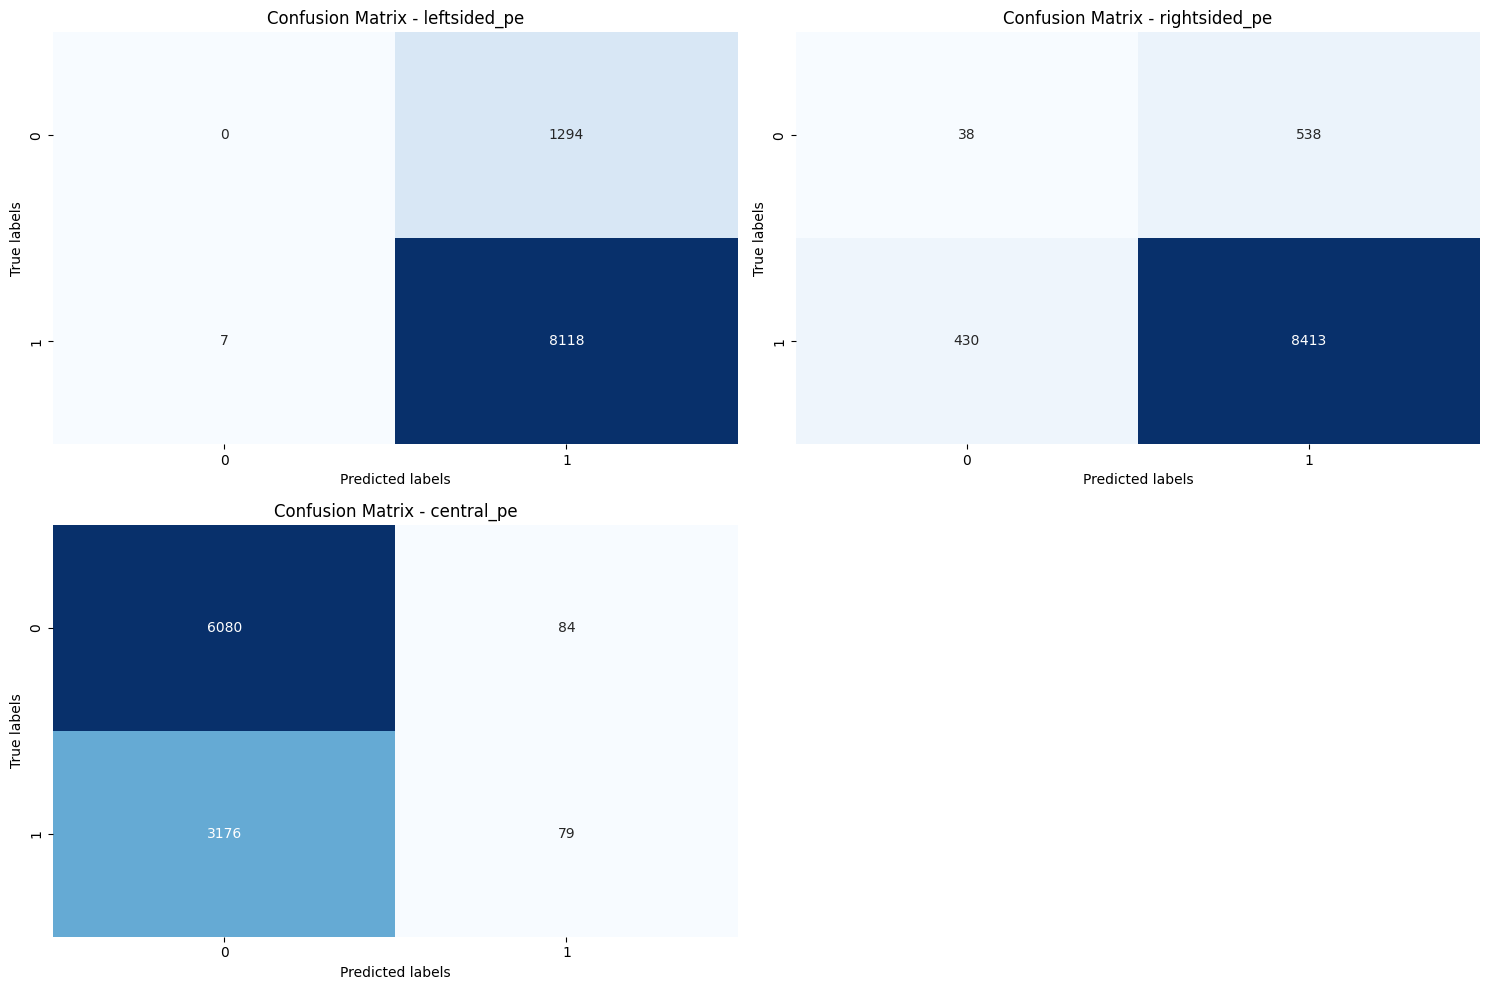

Precision por clase:  [0.86251594 0.93989498 0.48466258]
Recall por clase:  [0.99913846 0.95137397 0.02427035]
F1-Score por clase:  [0.92581399 0.94559964 0.04622586]

Matriz de Confusión:
 [[8118    7]
 [1294    0]]

Reporte Completo:
                precision    recall  f1-score   support

 leftsided_pe       0.86      1.00      0.93      8125
rightsided_pe       0.94      0.95      0.95      8843
   central_pe       0.48      0.02      0.05      3255

    micro avg       0.90      0.82      0.86     20223
    macro avg       0.76      0.66      0.64     20223
 weighted avg       0.84      0.82      0.79     20223
  samples avg       0.89      0.86      0.85     20223



In [26]:
import seaborn as sns

def multilabel_confusion_matrix(true_labels, predicted_labels, num_classes):
    confusion_matrix = np.zeros((num_classes, 2, 2), dtype=np.int32)
    
    for i in range(num_classes):
        true_positive = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 1))
        false_negative = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 0))
        false_positive = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 1))
        true_negative = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 0))
        
        confusion_matrix[i] = np.array([[true_negative, false_positive],
                                        [false_negative, true_positive]])
    return confusion_matrix

num_classes = true_labels.shape[1]  
class_names = ['leftsided_pe','rightsided_pe', 'central_pe']

predicted_labels = np.round(predictions)

conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(15, 10))  
rows = (num_classes + 1) // 2  

for i in range(num_classes):
    plt.subplot(rows, 2, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f"Confusion Matrix - {class_names[i]}")

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda().float()
            labels = labels.cuda().float()
            preds = model(imgs)
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)
    cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
    
    print("Precision por clase: ", precision)
    print("Recall por clase: ", recall)
    print("F1-Score por clase: ", f1)
    print("\nMatriz de Confusión:\n", cm)
    print("\nReporte Completo:\n", classification_report(all_labels, all_preds, target_names=[ 'leftsided_pe', 'rightsided_pe', 'central_pe']))


evaluate_model(model, final_val)

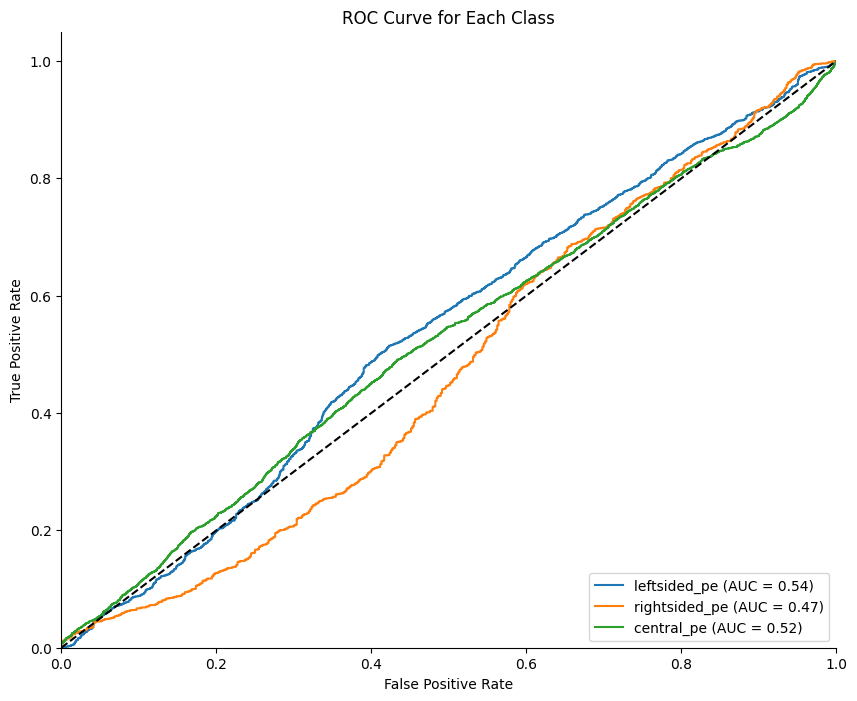

In [30]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(true_labels, predicted_probs, label_names):
    plt.figure(figsize=(10, 8))
    
    for i, label_name in enumerate(label_names):
        fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(label_name, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    sns.despine()
    plt.show()

label_names = ['leftsided_pe', 'rightsided_pe', 'central_pe']
plot_roc_curve(true_labels, predictions, label_names)

In [31]:
predictions = []
true_labels = []
for images, labels in val:
    images = images.cuda().float()
    true_labels.extend(labels.cpu().numpy())
    with torch.no_grad():
        pred = Trainer.predict(images)
        predictions.extend(pred.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

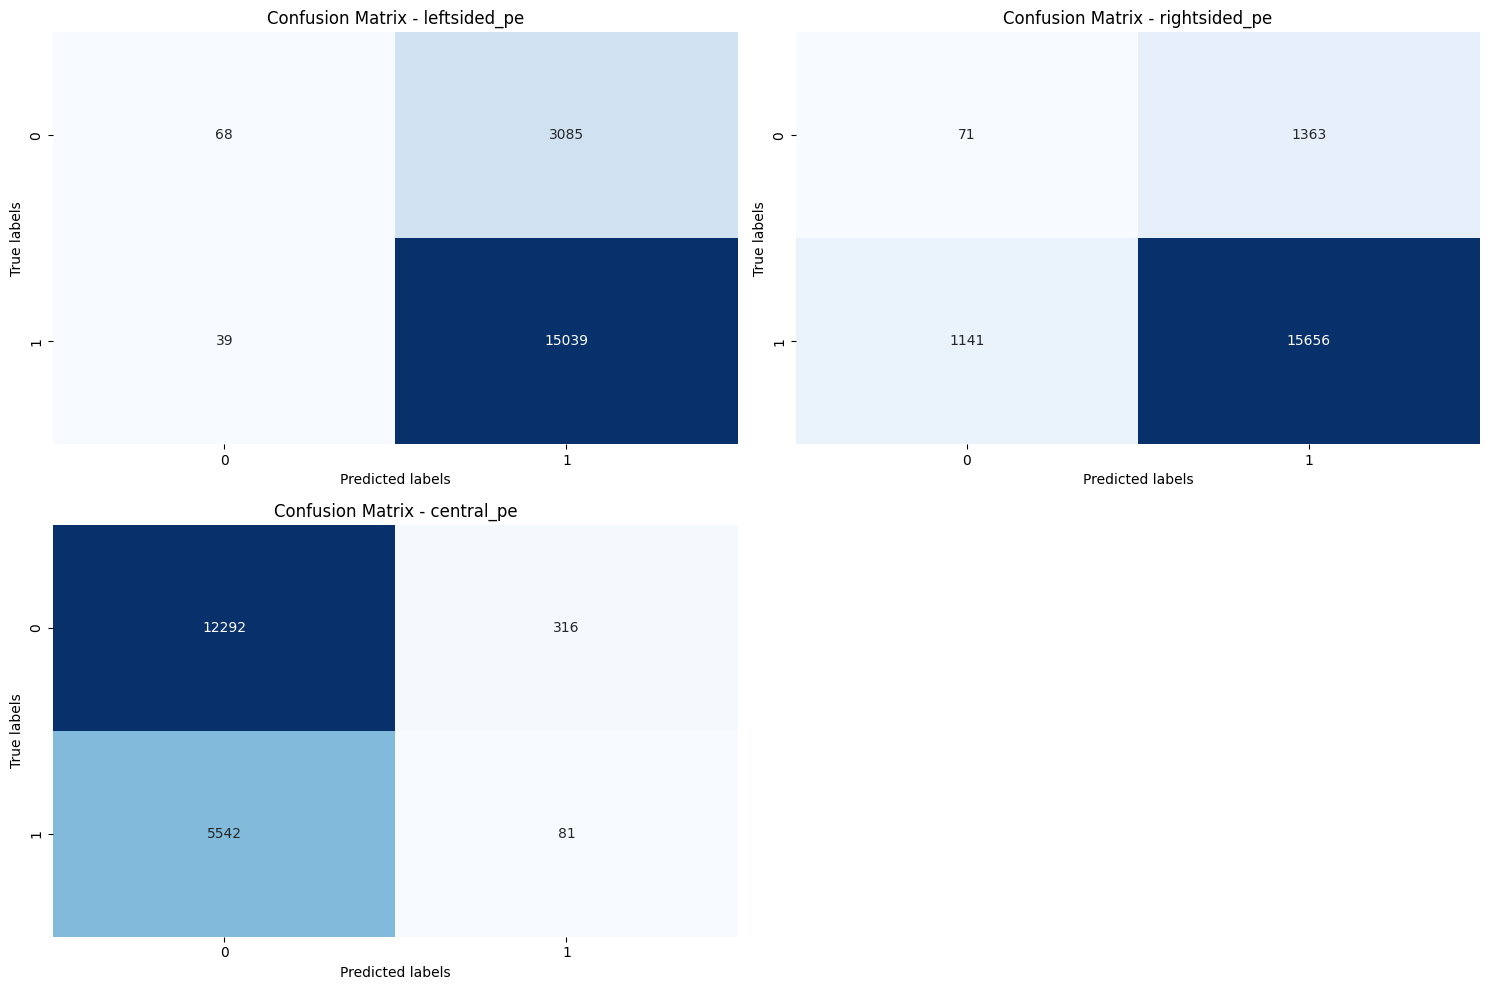

Precision por clase:  [0.82978371 0.91991304 0.20403023]
Recall por clase:  [0.99741345 0.9320712  0.01440512]
F1-Score por clase:  [0.90590928 0.92595221 0.0269103 ]

Matriz de Confusión:
 [[15039    39]
 [ 3085    68]]

Reporte Completo:
                precision    recall  f1-score   support

 leftsided_pe       0.83      1.00      0.91     15078
rightsided_pe       0.92      0.93      0.93     16797
   central_pe       0.20      0.01      0.03      5623

    micro avg       0.87      0.82      0.84     37498
    macro avg       0.65      0.65      0.62     37498
 weighted avg       0.78      0.82      0.78     37498
  samples avg       0.87      0.86      0.83     37498



In [32]:
def multilabel_confusion_matrix(true_labels, predicted_labels, num_classes):
    confusion_matrix = np.zeros((num_classes, 2, 2), dtype=np.int32)
    
    for i in range(num_classes):
        true_positive = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 1))
        false_negative = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 0))
        false_positive = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 1))
        true_negative = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 0))
        
        confusion_matrix[i] = np.array([[true_negative, false_positive],
                                        [false_negative, true_positive]])
    return confusion_matrix

num_classes = true_labels.shape[1]  
class_names = ['leftsided_pe','rightsided_pe', 'central_pe']

predicted_labels = np.round(predictions)

conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(15, 10))  
rows = (num_classes + 1) // 2  

for i in range(num_classes):
    plt.subplot(rows, 2, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f"Confusion Matrix - {class_names[i]}")

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda().float()
            labels = labels.cuda().float()
            preds = model(imgs)
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)
    cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
    
    print("Precision por clase: ", precision)
    print("Recall por clase: ", recall)
    print("F1-Score por clase: ", f1)
    print("\nMatriz de Confusión:\n", cm)
    print("\nReporte Completo:\n", classification_report(all_labels, all_preds, target_names=[ 'leftsided_pe', 'rightsided_pe', 'central_pe']))


evaluate_model(model, val)

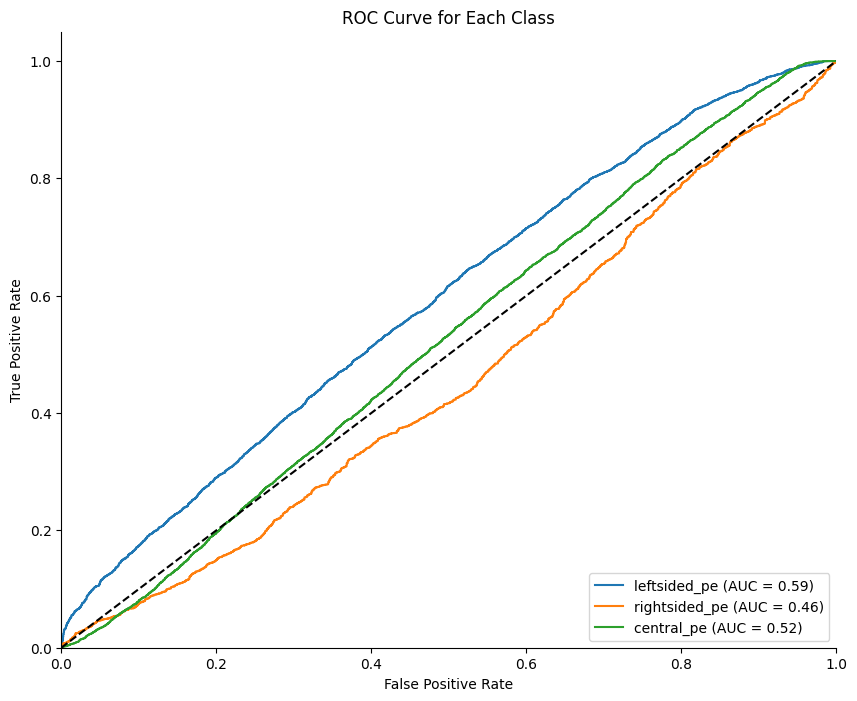

In [33]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(true_labels, predicted_probs, label_names):
    plt.figure(figsize=(10, 8))
    
    for i, label_name in enumerate(label_names):
        fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(label_name, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    sns.despine()
    plt.show()
label_names = ['leftsided_pe', 'rightsided_pe', 'central_pe']

plot_roc_curve(true_labels, predictions, label_names)

# Model 2 (Disease Condition: CHRONIC_PE, ACUTE_AND_CHRONIC_PE)

In [10]:
model2_columnas_a_mantener = [
    'StudyInstanceUID', 
    'SeriesInstanceUID', 
    'SOPInstanceUID',  
    'chronic_pe', 
    'acute_and_chronic_pe'
]

# Filter
df_model2 = df_disease[model2_columnas_a_mantener]

print(df_model2)

        StudyInstanceUID SeriesInstanceUID SOPInstanceUID  chronic_pe  \
63          6897fa9de148      2bfbb7fd2e8b   c1a5538bba20           0   
64          6897fa9de148      2bfbb7fd2e8b   fd9db7e0cffe           0   
65          6897fa9de148      2bfbb7fd2e8b   1f108fe8cae4           0   
75          6897fa9de148      2bfbb7fd2e8b   2a6b4c0ef0e5           0   
76          6897fa9de148      2bfbb7fd2e8b   21c2645ae16d           0   
...                  ...               ...            ...         ...   
1592590     4833c9b6a5d0      57e3e3c5f910   6f696c439df7           1   
1592591     4833c9b6a5d0      57e3e3c5f910   48ecddad6ec3           1   
1592592     4833c9b6a5d0      57e3e3c5f910   40f943bb1e01           1   
1592602     4833c9b6a5d0      57e3e3c5f910   3696e01d1286           1   
1592612     4833c9b6a5d0      57e3e3c5f910   f890efd48940           1   

         acute_and_chronic_pe  
63                          0  
64                          0  
65                         

In [11]:
def get_training_augmentation(y=256, x=256):
    train_transform = [
        albu.VerticalFlip(p=0.5),
        albu.HorizontalFlip(p=0.5),
        albu.Rotate(limit=20, p=0.5),
        albu.CenterCrop(height=int(y * 0.7), width=int(x * 0.7), p=1.0),
        albu.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        albu.GridDistortion(p=0.3),
        albu.Downscale(p=0.5, scale_min=0.35, scale_max=0.75),
        albu.ToGray(p=1.0),
        albu.Resize(y, x)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation(y=256, x=256):
    test_transform = [
        albu.CenterCrop(height=int(y * 0.7), width=int(x * 0.7), p=1.0),
        albu.Resize(y, x)
    ]
    return albu.Compose(test_transform)

In [12]:
StudyInstanceUID = list(set(df_model2['StudyInstanceUID']))
print(len(StudyInstanceUID))

2084


In [13]:
t_df = df_model2[df_model2['StudyInstanceUID'].isin(StudyInstanceUID[0:1447])] #70% train 
v_df = df_model2[df_model2['StudyInstanceUID'].isin(StudyInstanceUID[1447:1860])] #20% validation-test
final_val_df = df_model2[df_model2['StudyInstanceUID'].isin(StudyInstanceUID[1860:2084])] #10% validation-test

In [14]:
class config:
    model_name="Model 2 Disease Condition - multiclass"
    batch_size = 128
    WORKERS = 4
    classes = 2
    resume = False
    epochs = 5
    MODEL_PATH = 'log/cpt'
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

In [15]:
formatted_settings = {
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],}

preprocessing_fn = functools.partial(preprocess_input, **formatted_settings)

train_dataset = CTDataset2D(t_df,
                            transforms=get_training_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn),mode='train')

val_dataset = CTDataset2D(v_df,
                            transforms=get_validation_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn))

final_val_dataset = CTDataset2D(final_val_df,
                            transforms=get_validation_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn))

In [16]:
train = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.WORKERS, pin_memory=True) 
val = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.WORKERS, pin_memory=True) 
final_val = DataLoader(final_val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.WORKERS, pin_memory=True) 

In [17]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 133MB/s] 


Loaded pretrained weights for efficientnet-b0


In [18]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay= 0.00001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max= 300,eta_min= 0.00001)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [19]:
Trainer = trainer(loss_fn,model,optimizer,scheduler)
Trainer.run(train,val)

----------Epoch 0-----------


  0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

metric 0.6194596092256022
----------Epoch 1-----------


  0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b39a4721000>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7b39a4721000>can only test a child process

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7b39a4721000>

  File "/opt/conda/lib/python3.10/site-packages/torch/u

metric 0.6061683618266818
----------Epoch 2-----------


  0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b39a4721000>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b39a4721000>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b39a4721000>
Exception ignored in:   File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b39a472

metric -0.1783155347679708
----------Epoch 3-----------


  0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b39a4721000>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b39a4721000>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/op

metric 0.39031677535721954
----------Epoch 4-----------


  0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b39a4721000>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b39a4721000>
Exception ignored in: Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b39a4721000>    
self._shutdown_workers()Traceback (most recent call last):
  File "/opt/conda/li

metric 0.41741486187552057


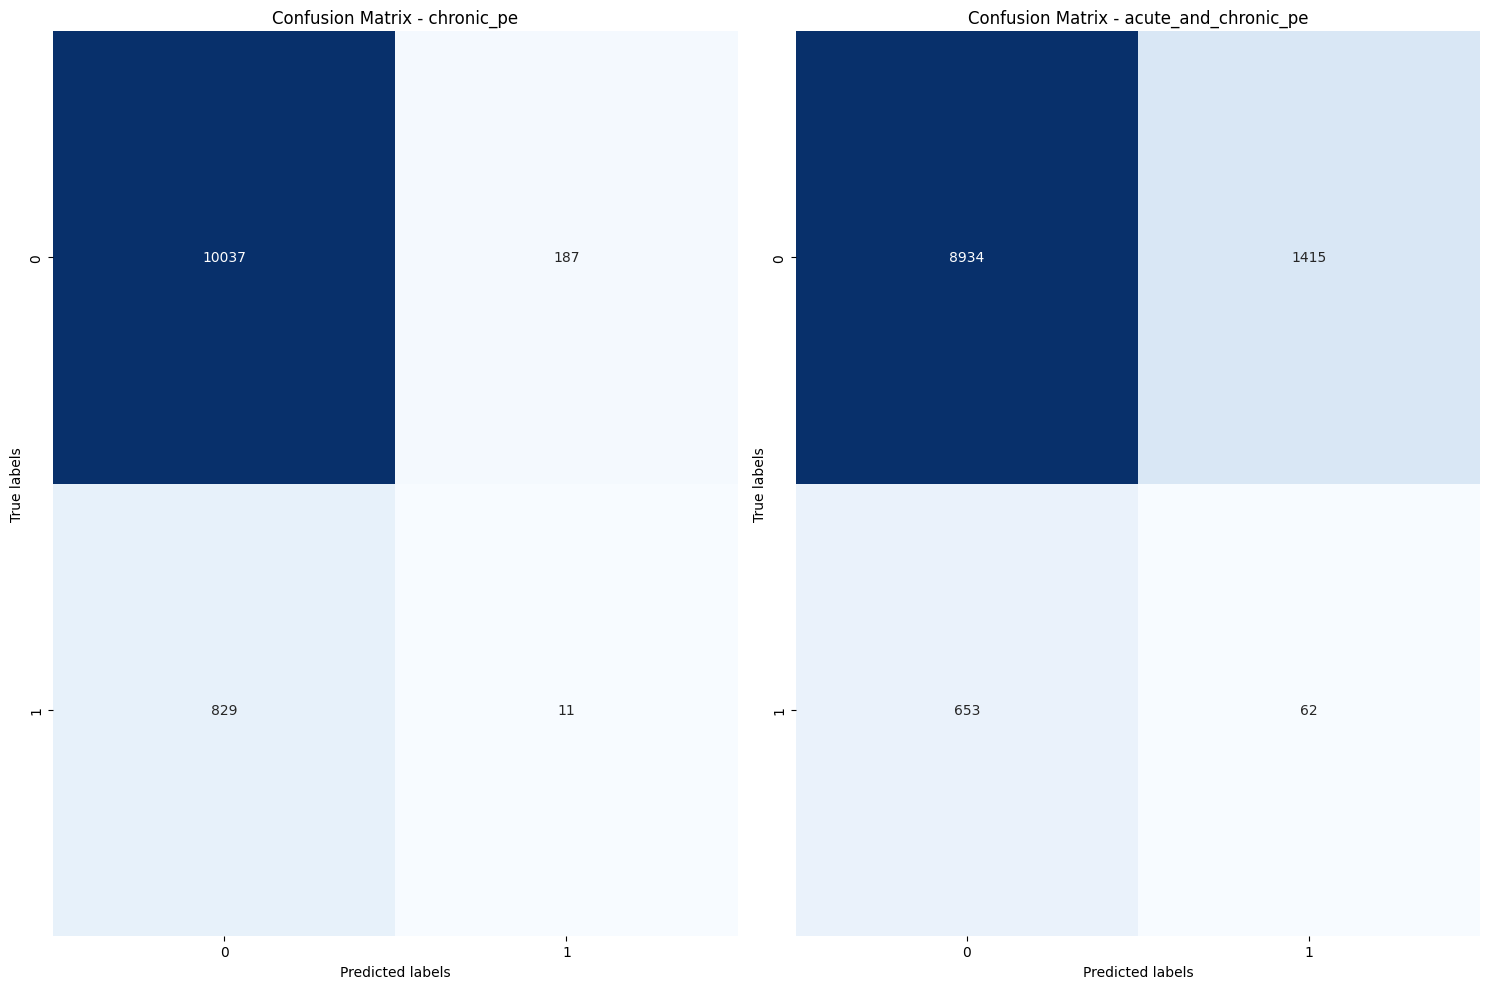

Precision por clase:  [0.05555556 0.04197698]
Recall por clase:  [0.01309524 0.08671329]
F1-Score por clase:  [0.02119461 0.05656934]

Matriz de Confusión:
 [[9034 1315]
 [ 653   62]]

Reporte Completo:
                       precision    recall  f1-score   support

          chronic_pe       0.06      0.01      0.02       840
acute_and_chronic_pe       0.04      0.09      0.06       715

           micro avg       0.04      0.05      0.05      1555
           macro avg       0.05      0.05      0.04      1555
        weighted avg       0.05      0.05      0.04      1555
         samples avg       0.01      0.01      0.01      1555



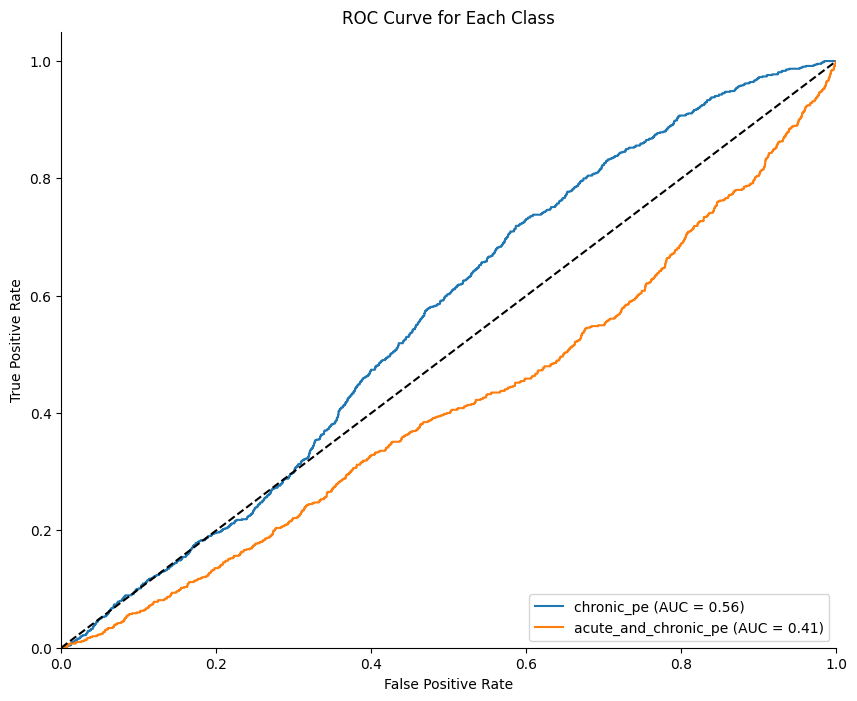

In [20]:
# final_val = 10%

predictions = []
true_labels = []
for images, labels in final_val:
    images = images.cuda().float()
    true_labels.extend(labels.cpu().numpy())
    with torch.no_grad():
        pred = Trainer.predict(images)
        predictions.extend(pred.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

import seaborn as sns

def multilabel_confusion_matrix(true_labels, predicted_labels, num_classes):
    confusion_matrix = np.zeros((num_classes, 2, 2), dtype=np.int32)
    
    for i in range(num_classes):
        true_positive = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 1))
        false_negative = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 0))
        false_positive = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 1))
        true_negative = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 0))
        
        confusion_matrix[i] = np.array([[true_negative, false_positive],
                                        [false_negative, true_positive]])
    return confusion_matrix

num_classes = true_labels.shape[1]  
class_names = ['chronic_pe','acute_and_chronic_pe']

predicted_labels = np.round(predictions)

conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(15, 10))  
rows = (num_classes + 1) // 2 

for i in range(num_classes):
    plt.subplot(rows, 2, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f"Confusion Matrix - {class_names[i]}")

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda().float()
            labels = labels.cuda().float()
            preds = model(imgs)
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)
    cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
    
    print("Precision por clase: ", precision)
    print("Recall por clase: ", recall)
    print("F1-Score por clase: ", f1)
    print("\nMatriz de Confusión:\n", cm)
    print("\nReporte Completo:\n", classification_report(all_labels, all_preds, target_names=[ 'chronic_pe', 'acute_and_chronic_pe']))


evaluate_model(model, final_val)

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(true_labels, predicted_probs, label_names):
    plt.figure(figsize=(10, 8))
    
    for i, label_name in enumerate(label_names):
        # fpr(False Positive Rate); tpr (True Positive Rate) 
        fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(label_name, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    sns.despine()
    plt.show()

label_names = ['chronic_pe', 'acute_and_chronic_pe']

plot_roc_curve(true_labels, predictions, label_names)

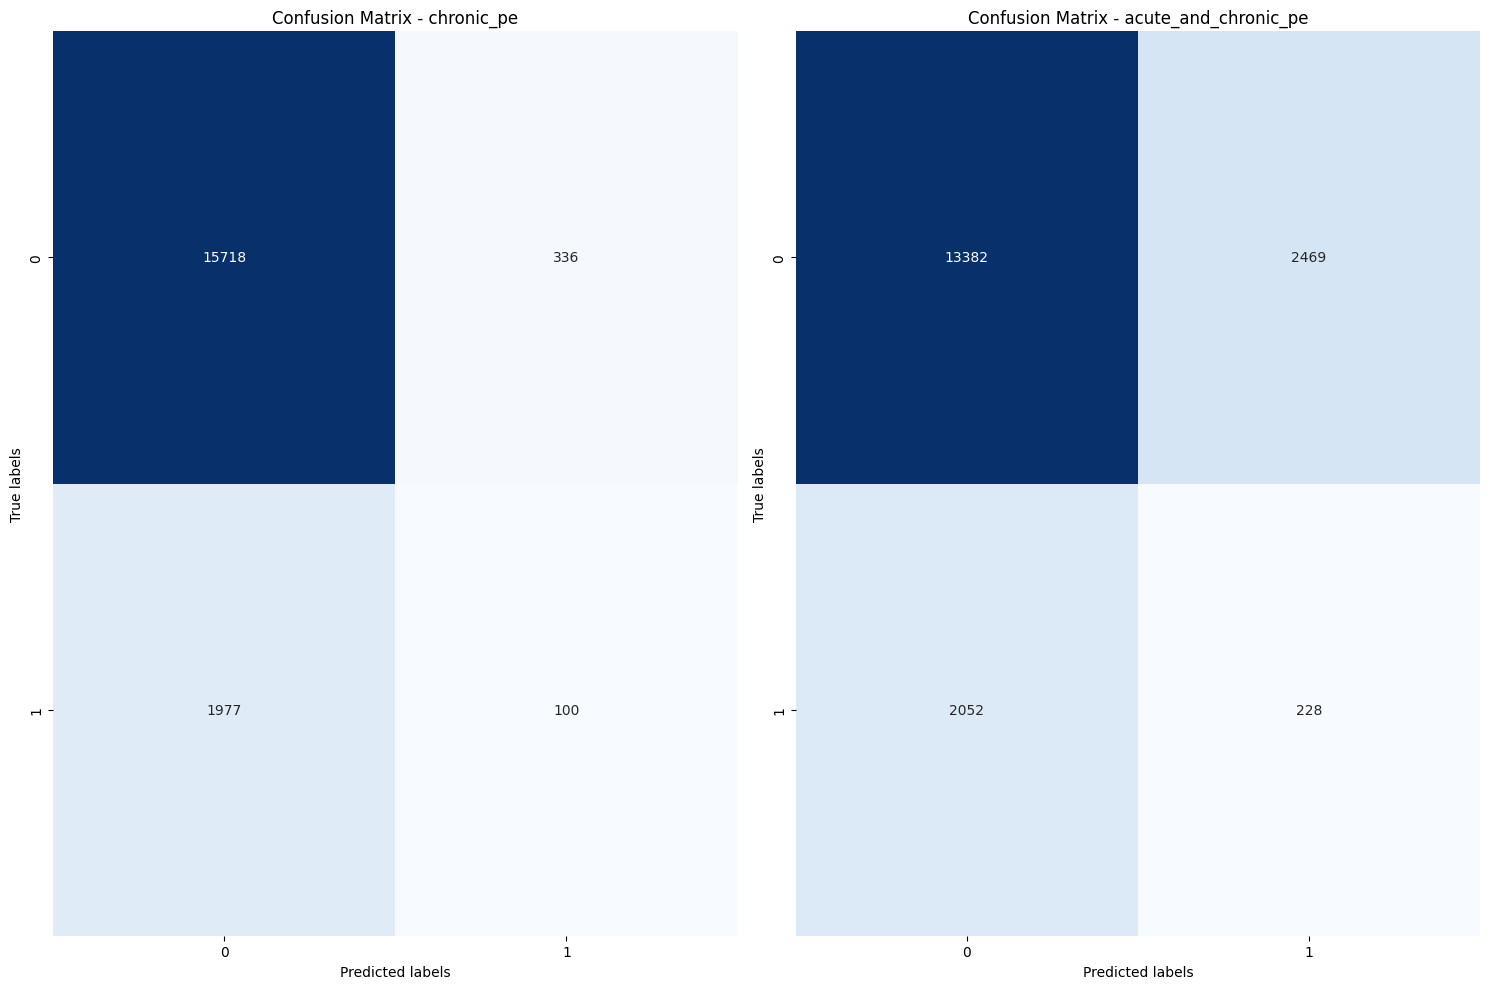

Precision por clase:  [0.2293578  0.08453838]
Recall por clase:  [0.04814636 0.1       ]
F1-Score por clase:  [0.07958615 0.09162146]

Matriz de Confusión:
 [[13566  2285]
 [ 2062   218]]

Reporte Completo:
                       precision    recall  f1-score   support

          chronic_pe       0.23      0.05      0.08      2077
acute_and_chronic_pe       0.08      0.10      0.09      2280

           micro avg       0.10      0.08      0.09      4357
           macro avg       0.16      0.07      0.09      4357
        weighted avg       0.15      0.08      0.09      4357
         samples avg       0.02      0.02      0.02      4357



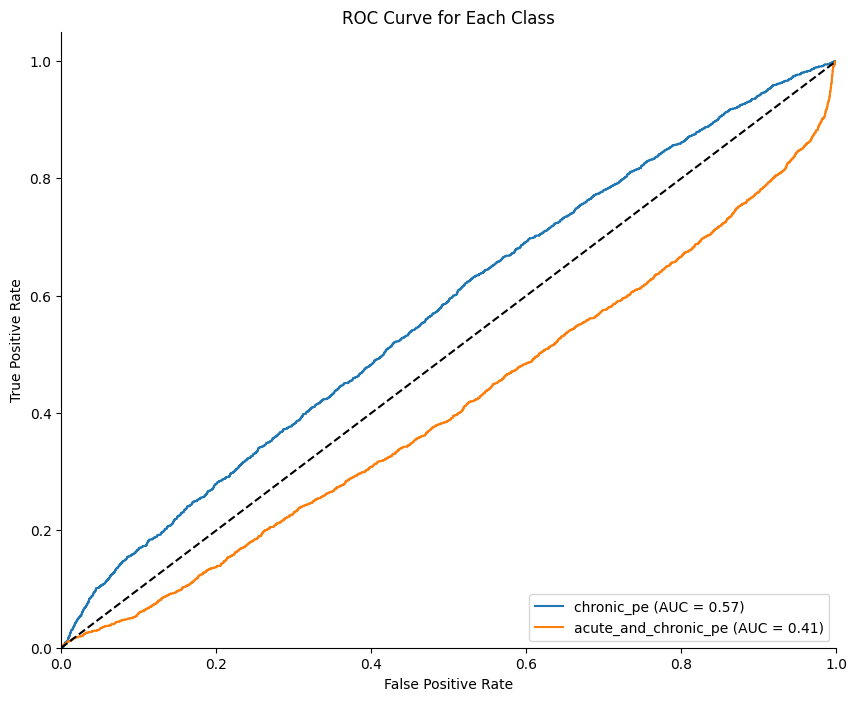

In [21]:
# val = 20%

predictions = []
true_labels = []
for images, labels in val:
    images = images.cuda().float()
    true_labels.extend(labels.cpu().numpy())
    with torch.no_grad():
        pred = Trainer.predict(images)
        predictions.extend(pred.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

def multilabel_confusion_matrix(true_labels, predicted_labels, num_classes):
    confusion_matrix = np.zeros((num_classes, 2, 2), dtype=np.int32)
    
    for i in range(num_classes):
        true_positive = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 1))
        false_negative = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 0))
        false_positive = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 1))
        true_negative = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 0))
        
        confusion_matrix[i] = np.array([[true_negative, false_positive],
                                        [false_negative, true_positive]])
    return confusion_matrix

num_classes = true_labels.shape[1]  
class_names = ['chronic_pe','acute_and_chronic_pe']

predicted_labels = np.round(predictions)

conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(15, 10))  
rows = (num_classes + 1) // 2 

for i in range(num_classes):
    plt.subplot(rows, 2, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f"Confusion Matrix - {class_names[i]}")

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda().float()
            labels = labels.cuda().float()
            preds = model(imgs)
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)
    cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
    
    print("Precision por clase: ", precision)
    print("Recall por clase: ", recall)
    print("F1-Score por clase: ", f1)
    print("\nMatriz de Confusión:\n", cm)
    print("\nReporte Completo:\n", classification_report(all_labels, all_preds, target_names=[ 'chronic_pe', 'acute_and_chronic_pe']))


evaluate_model(model, val)

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(true_labels, predicted_probs, label_names):
    plt.figure(figsize=(10, 8))
    
    for i, label_name in enumerate(label_names):
        # fpr(False Positive Rate); tpr (True Positive Rate) 
        fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(label_name, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    sns.despine()
    plt.show()

label_names = ['chronic_pe', 'acute_and_chronic_pe']

plot_roc_curve(true_labels, predictions, label_names)

# Model 3 (Heart Ratio Condition: RV_LV_RATIO_GTE_1, RV_LV_RATIO_LT_1)

In [10]:
model3_columnas_a_mantener = [
    'StudyInstanceUID', 
    'SeriesInstanceUID', 
    'SOPInstanceUID',  
    'rv_lv_ratio_gte_1', 
    'rv_lv_ratio_lt_1'
]

# Filter
df_model3 = df_disease[model3_columnas_a_mantener]

print(df_model3)

        StudyInstanceUID SeriesInstanceUID SOPInstanceUID  rv_lv_ratio_gte_1  \
63          6897fa9de148      2bfbb7fd2e8b   c1a5538bba20                  0   
64          6897fa9de148      2bfbb7fd2e8b   fd9db7e0cffe                  0   
65          6897fa9de148      2bfbb7fd2e8b   1f108fe8cae4                  0   
75          6897fa9de148      2bfbb7fd2e8b   2a6b4c0ef0e5                  0   
76          6897fa9de148      2bfbb7fd2e8b   21c2645ae16d                  0   
...                  ...               ...            ...                ...   
1592590     4833c9b6a5d0      57e3e3c5f910   6f696c439df7                  0   
1592591     4833c9b6a5d0      57e3e3c5f910   48ecddad6ec3                  0   
1592592     4833c9b6a5d0      57e3e3c5f910   40f943bb1e01                  0   
1592602     4833c9b6a5d0      57e3e3c5f910   3696e01d1286                  0   
1592612     4833c9b6a5d0      57e3e3c5f910   f890efd48940                  0   

         rv_lv_ratio_lt_1  
63         

In [12]:
def get_training_augmentation(y=256, x=256):
    train_transform = [
        albu.VerticalFlip(p=0.5),
        albu.HorizontalFlip(p=0.5),
        albu.Rotate(limit=20, p=0.5),
        albu.CenterCrop(height=int(y * 0.5), width=int(x * 0.5), p=1.0),
        albu.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        albu.GridDistortion(p=0.3),
        albu.Downscale(p=0.5, scale_min=0.35, scale_max=0.75),
        albu.ToGray(p=1.0),  # Aplicar escala de grises
        albu.Resize(y, x)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation(y=256, x=256):
    test_transform = [
        albu.CenterCrop(height=int(y * 0.5), width=int(x * 0.5), p=1.0),
        albu.Resize(y, x)
    ]
    return albu.Compose(test_transform)

In [13]:
StudyInstanceUID = list(set(df_model3['StudyInstanceUID']))
print(len(StudyInstanceUID))

2084


In [14]:
t_df = df_model3[df_model3['StudyInstanceUID'].isin(StudyInstanceUID[0:1447])] #70% train 
v_df = df_model3[df_model3['StudyInstanceUID'].isin(StudyInstanceUID[1447:1860])] #20% validation-test
final_val_df = df_model3[df_model3['StudyInstanceUID'].isin(StudyInstanceUID[1860:2068])] #10% validation-test

In [15]:
class config:
    model_name="Model 3 Hearth Ratio - multiclass"
    batch_size = 128
    WORKERS = 4
    classes = 2
    resume = False
    epochs = 5
    MODEL_PATH = 'log/cpt'
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

In [16]:
formatted_settings = {
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],}

preprocessing_fn = functools.partial(preprocess_input, **formatted_settings)

train_dataset = CTDataset2D(t_df,
                            transforms=get_training_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn),mode='train')

val_dataset = CTDataset2D(v_df,
                            transforms=get_validation_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn))

final_val_dataset = CTDataset2D(final_val_df,
                            transforms=get_validation_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn))

In [17]:
train = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.WORKERS, pin_memory=True) 
val = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.WORKERS, pin_memory=True) 
final_val = DataLoader(final_val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.WORKERS, pin_memory=True) 

In [18]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 276MB/s]


Loaded pretrained weights for efficientnet-b0


In [19]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay= 0.00001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max= 300,eta_min= 0.00001)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [20]:
Trainer = trainer(loss_fn,model,optimizer,scheduler)
Trainer.run(train,val)

----------Epoch 0-----------


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

metric 0.2742443052056719
----------Epoch 1-----------


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c601d3d000>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c601d3d000>
if w.is_alive():Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        Exception ignored in: self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x79c601d3d000>


Traceback (most recent call last):
AssertionError  File "/opt/conda/lib/python3.10/site-packages/torc

metric 0.3100051059298319
----------Epoch 2-----------


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

metric 0.3132991325365352
----------Epoch 3-----------


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

metric 0.2297623843362887
----------Epoch 4-----------


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

metric 0.30975295501212574


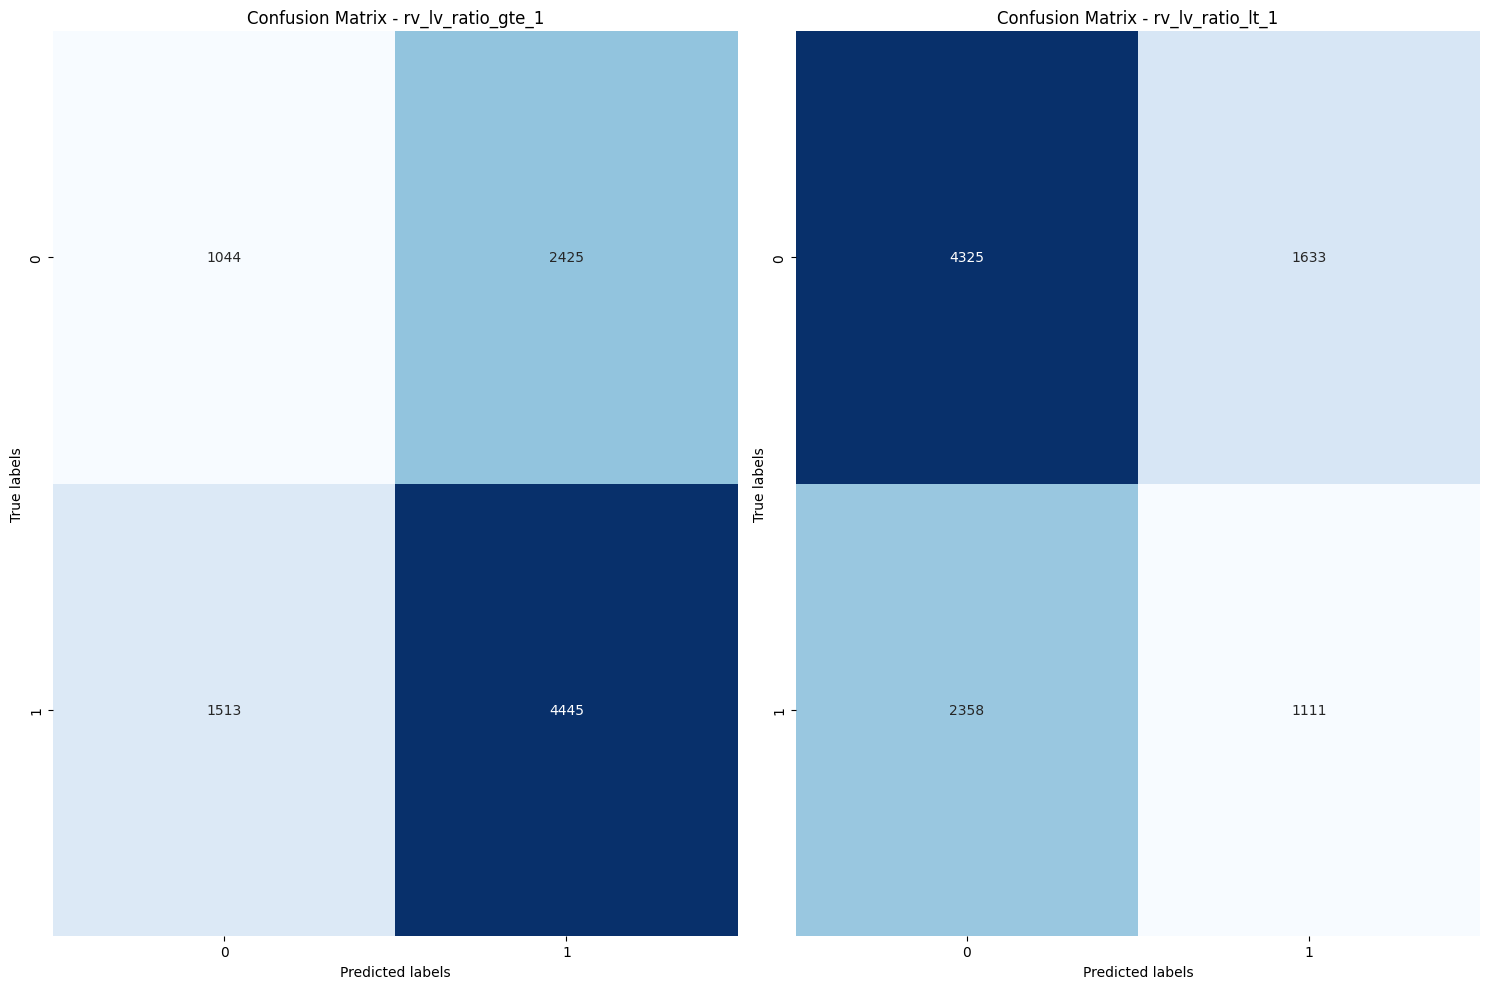

Precision por clase:  [0.64701601 0.40488338]
Recall por clase:  [0.74605572 0.32026521]
F1-Score por clase:  [0.69301528 0.35763721]

Matriz de Confusión:
 [[4448 1510]
 [2425 1044]]

Reporte Completo:
                    precision    recall  f1-score   support

rv_lv_ratio_gte_1       0.65      0.75      0.69      5958
 rv_lv_ratio_lt_1       0.40      0.32      0.36      3469

        micro avg       0.58      0.59      0.58      9427
        macro avg       0.53      0.53      0.53      9427
     weighted avg       0.56      0.59      0.57      9427
      samples avg       0.58      0.59      0.58      9427



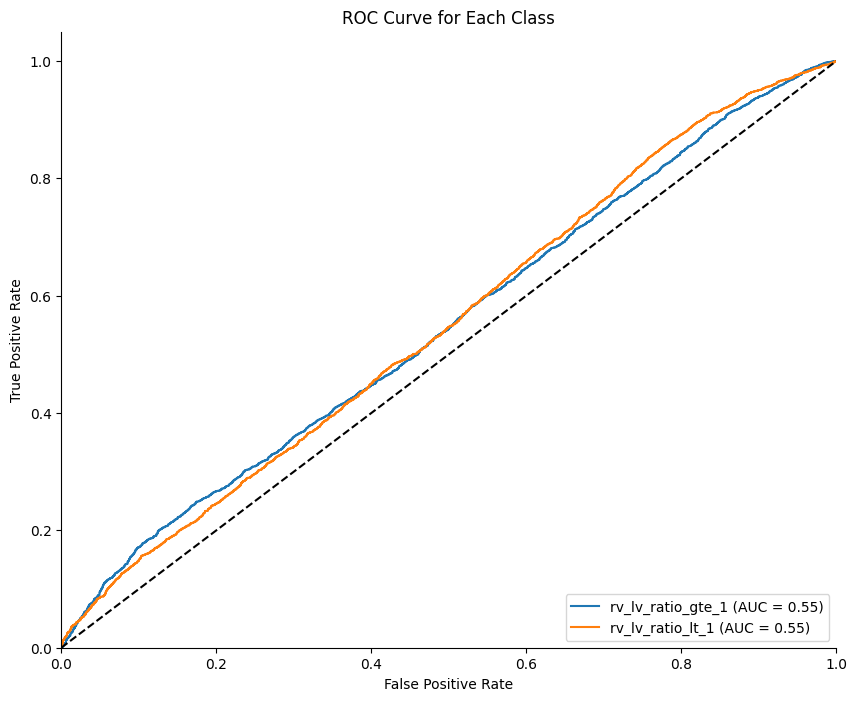

In [21]:
# final_val = 10%

predictions = []
true_labels = []
for images, labels in final_val:
    images = images.cuda().float()
    true_labels.extend(labels.cpu().numpy())
    with torch.no_grad():
        pred = Trainer.predict(images)
        predictions.extend(pred.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)


import seaborn as sns

def multilabel_confusion_matrix(true_labels, predicted_labels, num_classes):
    confusion_matrix = np.zeros((num_classes, 2, 2), dtype=np.int32)
    
    for i in range(num_classes):
        true_positive = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 1))
        false_negative = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 0))
        false_positive = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 1))
        true_negative = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 0))
        
        confusion_matrix[i] = np.array([[true_negative, false_positive],
                                        [false_negative, true_positive]])
    return confusion_matrix

num_classes = true_labels.shape[1]  
class_names = ['rv_lv_ratio_gte_1','rv_lv_ratio_lt_1']

predicted_labels = np.round(predictions)

conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(15, 10))  
rows = (num_classes + 1) // 2 

for i in range(num_classes):
    plt.subplot(rows, 2, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f"Confusion Matrix - {class_names[i]}")

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda().float()
            labels = labels.cuda().float()
            preds = model(imgs)
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)
    cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
    
    print("Precision por clase: ", precision)
    print("Recall por clase: ", recall)
    print("F1-Score por clase: ", f1)
    print("\nMatriz de Confusión:\n", cm)
    print("\nReporte Completo:\n", classification_report(all_labels, all_preds, target_names=['rv_lv_ratio_gte_1','rv_lv_ratio_lt_1']))


evaluate_model(model, final_val)

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(true_labels, predicted_probs, label_names):
    plt.figure(figsize=(10, 8))
    
    for i, label_name in enumerate(label_names):
        # fpr(False Positive Rate); tpr (True Positive Rate) 
        fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(label_name, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    sns.despine()
    plt.show()

label_names = ['rv_lv_ratio_gte_1','rv_lv_ratio_lt_1']

plot_roc_curve(true_labels, predictions, label_names)

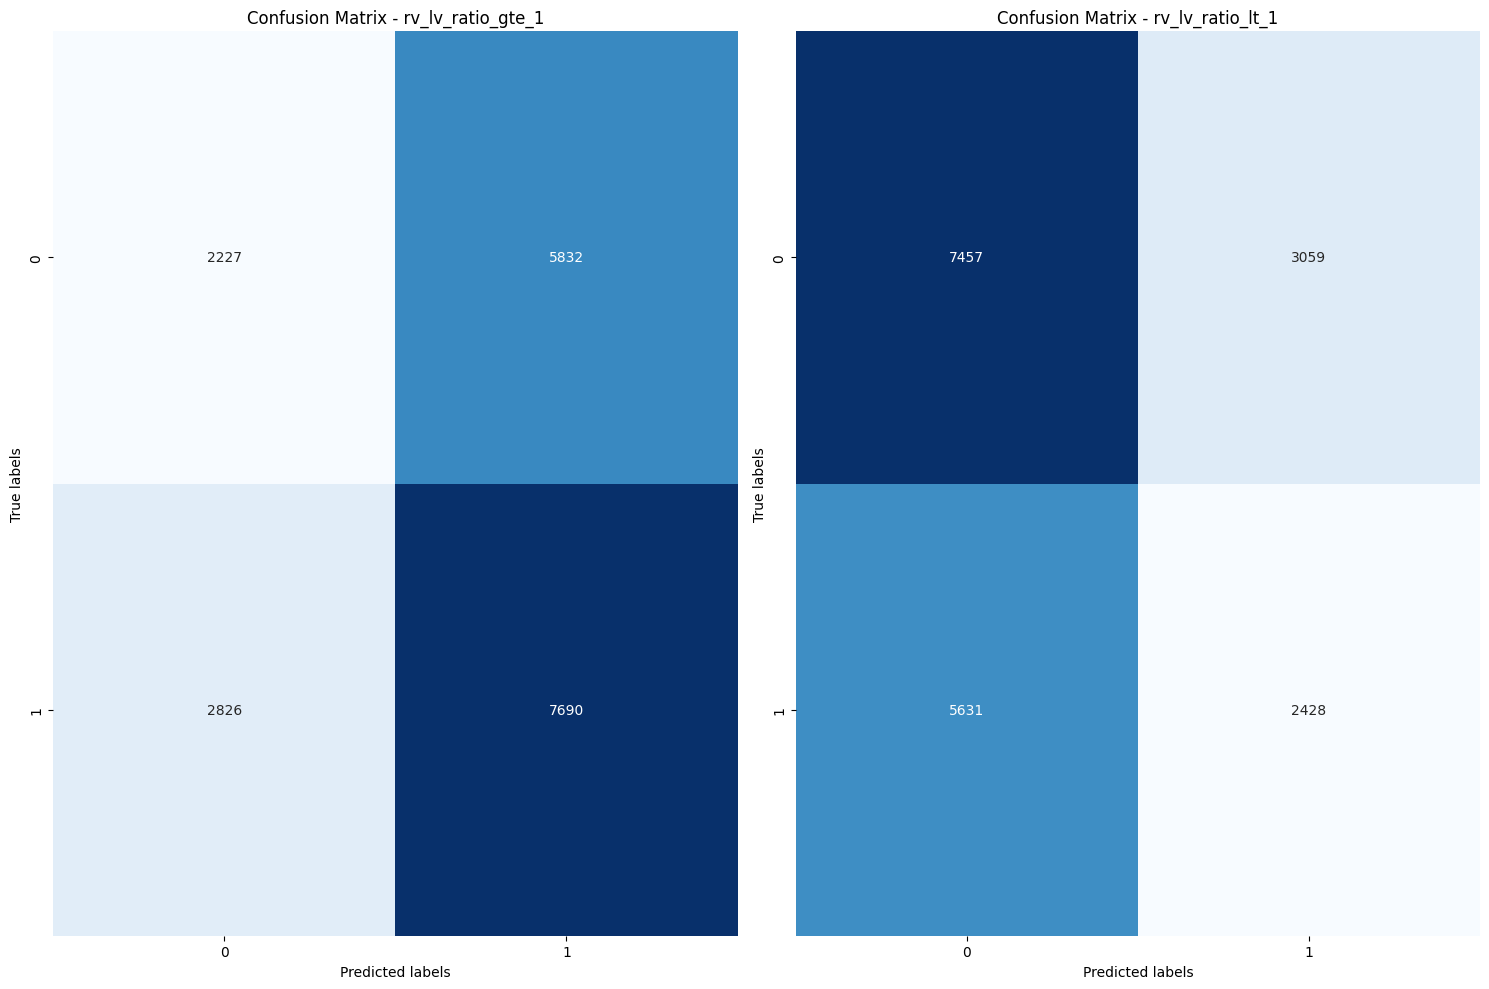

Precision por clase:  [0.56870285 0.44250046]
Recall por clase:  [0.73126664 0.30127807]
F1-Score por clase:  [0.63982028 0.35848221]

Matriz de Confusión:
 [[7692 2824]
 [5834 2225]]

Reporte Completo:
                    precision    recall  f1-score   support

rv_lv_ratio_gte_1       0.57      0.73      0.64     10516
 rv_lv_ratio_lt_1       0.44      0.30      0.36      8059

        micro avg       0.53      0.54      0.54     18575
        macro avg       0.51      0.52      0.50     18575
     weighted avg       0.51      0.54      0.52     18575
      samples avg       0.53      0.54      0.54     18575



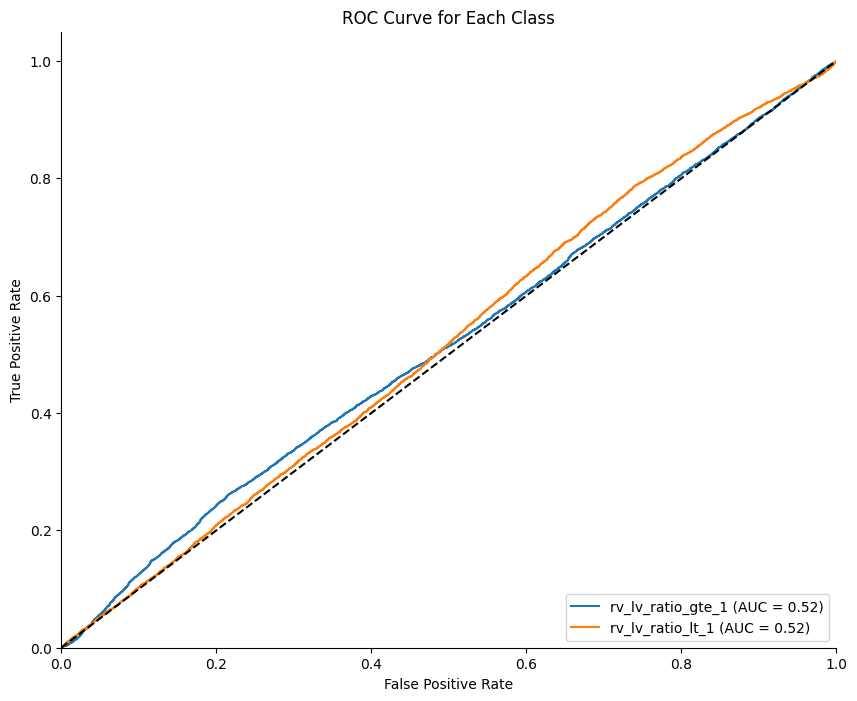

In [22]:
# val = 20%

predictions = []
true_labels = []
for images, labels in val:
    images = images.cuda().float()
    true_labels.extend(labels.cpu().numpy())
    with torch.no_grad():
        pred = Trainer.predict(images)
        predictions.extend(pred.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

def multilabel_confusion_matrix(true_labels, predicted_labels, num_classes):
    confusion_matrix = np.zeros((num_classes, 2, 2), dtype=np.int32)
    
    for i in range(num_classes):
        true_positive = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 1))
        false_negative = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 0))
        false_positive = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 1))
        true_negative = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 0))
        
        confusion_matrix[i] = np.array([[true_negative, false_positive],
                                        [false_negative, true_positive]])
    return confusion_matrix

num_classes = true_labels.shape[1]  
class_names = ['rv_lv_ratio_gte_1','rv_lv_ratio_lt_1']

predicted_labels = np.round(predictions)

conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(15, 10))  
rows = (num_classes + 1) // 2 

for i in range(num_classes):
    plt.subplot(rows, 2, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f"Confusion Matrix - {class_names[i]}")

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda().float()
            labels = labels.cuda().float()
            preds = model(imgs)
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)
    cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
    
    print("Precision por clase: ", precision)
    print("Recall por clase: ", recall)
    print("F1-Score por clase: ", f1)
    print("\nMatriz de Confusión:\n", cm)
    print("\nReporte Completo:\n", classification_report(all_labels, all_preds, target_names=['rv_lv_ratio_gte_1','rv_lv_ratio_lt_1']))


evaluate_model(model, val)

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(true_labels, predicted_probs, label_names):
    plt.figure(figsize=(10, 8))
    
    for i, label_name in enumerate(label_names):
        # fpr(False Positive Rate); tpr (True Positive Rate) 
        fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(label_name, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    sns.despine()
    plt.show()

label_names = ['rv_lv_ratio_gte_1','rv_lv_ratio_lt_1']

plot_roc_curve(true_labels, predictions, label_names)